<a href="https://colab.research.google.com/github/Satyam-kumar-yadav/StumbleUpon-Classification-/blob/main/StumbleUpon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
### importing drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# !unzip '/content/gdrive/MyDrive/BCG/stumbleupon.zip' -d '/content/gdrive/MyDrive/BCG'

Archive:  /content/gdrive/MyDrive/BCG/stumbleupon.zip
  inflating: /content/gdrive/MyDrive/BCG/raw_content.zip  
  inflating: /content/gdrive/MyDrive/BCG/sampleSubmission.csv  
  inflating: /content/gdrive/MyDrive/BCG/test.tsv  
  inflating: /content/gdrive/MyDrive/BCG/train.tsv  


In [229]:
### libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [230]:
### Config File 
train = '/content/gdrive/MyDrive/BCG/train.tsv'
test = '/content/gdrive/MyDrive/BCG/test.tsv'
sample = '/content/gdrive/MyDrive/BCG/sampleSubmission.csv'

In [231]:
train_df = pd.read_csv(train,sep='\t')
train_df.head(5)

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,0,0.090774,0,0.245831,0.003883,1,1,24,0,5424,170,8,0.152941,0.079130,0
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,0.468649,0.0,0,0.098707,0,0.203490,0.088652,1,1,40,0,4973,187,9,0.181818,0.125448,1
2,http://www.menshealth.com/health/flu-fighting-...,1164,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,0.525448,0.0,0,0.072448,0,0.226402,0.120536,1,1,55,0,2240,258,11,0.166667,0.057613,1
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,0.480725,0.0,0,0.095861,0,0.265656,0.035343,1,0,24,0,2737,120,5,0.041667,0.100858,1
4,http://bleacherreport.com/articles/1205138-the...,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,0.446143,0.0,0,0.024908,0,0.228887,0.050473,1,1,14,0,12032,162,10,0.098765,0.082569,0


In [232]:
test_df = pd.read_csv(test,sep='\t')
test_df.head(5)

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio
0,http://www.lynnskitchenadventures.com/2009/04/...,5865,"{""title"":""Homemade Enchilada Sauce Lynn s Kitc...",recreation,0.443906,2.558140,0.389706,0.257353,0.044118,0.022059,0.489572,0.0,0,0.067143,0,0.230285,0.199438,1,1,15,0,5643,136,3,0.242647,0.080597
1,http://lolpics.se/18552-stun-grenade-ar,782,"{""title"":""lolpics Stun grenade ar "",""body"":"" f...",culture_politics,0.135844,3.771429,0.461538,0.205128,0.051282,0.000000,0.782051,0.0,0,0.042857,0,0.365962,0.080000,?,1,62,0,382,39,2,0.128205,0.176471
2,http://www.xcelerationfitness.com/treadmills.html,6962,"{""title"":""Treadmills "",""body"":"" treadmills, st...",?,?,2.269565,0.495726,0.384615,0.170940,0.170940,1.250000,0.0,0,0.058824,0,0.161901,10.000000,?,1,42,0,2420,117,1,0.581197,0.125000
3,http://www.bloomberg.com/news/2012-02-06/syria...,7640,"{""title"":""Father s Tactics Used by Assad to Cr...",culture_politics,0.90259,2.523490,0.705502,0.346278,0.122977,0.090615,0.449366,0.0,0,0.058081,0,0.146593,0.005964,1,1,41,0,5559,309,10,0.038835,0.063126
4,http://www.wired.com/gadgetlab/2011/12/stem-tu...,3589,"{""title"":""Stem Turns Lemons and Limes Into Jui...",science_technology,0.486363,1.848000,0.470968,0.161290,0.032258,0.000000,0.453757,0.0,0,0.093023,0,0.244141,0.035714,1,0,34,0,2209,155,10,0.096774,0.065341


In [233]:
### Sample Submission
sampleSub = pd.read_csv(sample)
sampleSub.head(5)

,urlid,label
0,5865,0
1,782,0
2,6962,0
3,7640,0
4,3589,0


In [234]:
xtrain_df  = pd.DataFrame({
    'boilerplate': train_df.boilerplate.values,
    'label': train_df.label.values
})

In [235]:
xtrain_df.head(5)

,boilerplate,label
0,"{""title"":""IBM Sees Holographic Calls Air Breat...",0
1,"{""title"":""The Fully Electronic Futuristic Star...",1
2,"{""title"":""Fruits that Fight the Flu fruits tha...",1
3,"{""title"":""10 Foolproof Tips for Better Sleep ""...",1
4,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",0


In [238]:
xtrain_df.shape

(7395, 2)

In [239]:
xtrain_df.isnull().sum()

boilerplate    0
label          0
dtype: int64

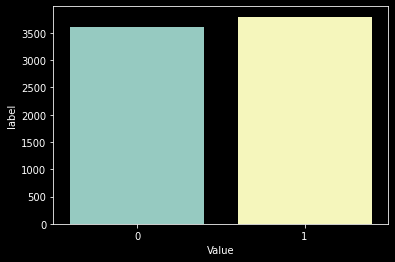

In [240]:
plt.style.use('dark_background')
sns.countplot(x='label',data=xtrain_df)
plt.xlabel('Value')
plt.ylabel('label')
plt.show()

In [241]:
X = []
for items in xtrain_df['boilerplate']:
    X.append(items)

In [242]:
from wordcloud import  WordCloud ,STOPWORDS

In [243]:
commonWord = ' '.join(X)
wordcloud = WordCloud(stopwords=STOPWORDS,height=2500,width=3000).generate(commonWord)

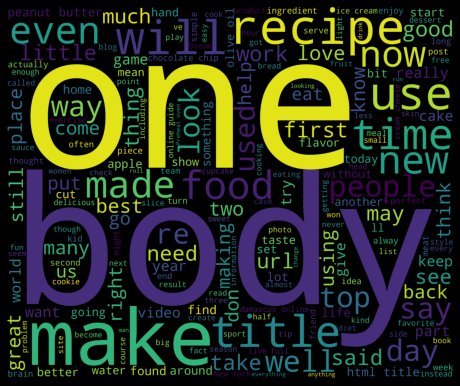

In [244]:
plt.figure(1,figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [245]:
del X, wordcloud

In [246]:
from sklearn.model_selection import train_test_split

In [247]:
X = xtrain_df.boilerplate.values
Y = xtrain_df.label.values
x_train,x_val,y_train,y_val = train_test_split(X,Y, test_size = 0.1 , random_state = 2021)

In [248]:
import torch
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


In [251]:
!pip install transformers

In [252]:
import string

Since I can't use greater then 512 len so I decided to preprocess the else it is not needed for the Bert model

In [253]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [254]:
from nltk.corpus import stopwords
en_stops = stopwords.words('english')
def remove_stop(text):
  return ' '.join([i for i in text.split() if i not in en_stops])

In [255]:
### Simple Preprocessing 
def processed_word(text):
  text = remove_stop(text)
  return ''.join([i for i in text if i not in string.punctuation ])
a = "This is for the intern"
print("Not processed :" ,a)
print("processed word :" ,processed_word(a))

Not processed : This is for the intern
processed word : This intern


In [256]:
### using based berttokenizer 
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case = True)

In [257]:
Max_len = 325

In [258]:
def preprocess_from_bert(data):
  input_ids = []
  attention_mask = []

  for item in data:
    token = tokenizer.encode_plus(
        text = processed_word(item),
        add_special_tokens=True,
        max_length = Max_len,
        # padding = 'max_length',
        pad_to_max_length = True,
        truncation = True,
        return_attention_mask =True,
    )
    input_ids.append(token.get('input_ids') )
    attention_mask.append(token.get('attention_mask'))
    
  input_ids = torch.tensor(input_ids)
  attention_mask = torch.tensor(attention_mask)

  return input_ids , attention_mask

In [262]:
train_inputs,train_masks = preprocess_from_bert(x_train)
val_inputs,val_masks = preprocess_from_bert(x_val)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



In [263]:
train_masks.shape

torch.Size([6655, 325])

In [264]:
##### DataLoader for train and validation dataset
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)
batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)


In [265]:
import torch
import torch.nn as nn
from transformers import BertModel
import torch.nn.functional as F

**Model**

In [267]:
#### using pretrained model for classification
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.fn = nn.Linear(768,80)
        self.drop = nn.Dropout(0.2)
        self.fn1 = nn.Linear(80,2)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        last_hidden_state_cls = outputs[0][:, 0, :]
        x = F.relu(self.fn(last_hidden_state_cls))
        x = self.drop(x)
        logits = self.fn1(x)
        return logits

In [268]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs):
    bert_classifier = BertClassifier(freeze_bert=False)
    bert_classifier.to(device)
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, 
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [269]:
import random
import time
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=2, evaluation=False):
    for epoch_i in range(epochs):
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)
        t0_epoch, t0_batch = time.time(), time.time()
        total_loss, batch_loss, batch_counts = 0, 0, 0
        model.train()
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
            model.zero_grad()
            logits = model(b_input_ids, b_attn_mask)
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                time_elapsed = time.time() - t0_batch
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        if evaluation == True:
            val_loss, val_accuracy = evaluate(model, val_dataloader)
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)

def evaluate(model, val_dataloader):
    model.eval()
    val_accuracy = []
    val_loss = []
    for batch in val_dataloader:
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())
        preds = torch.argmax(logits, dim=1).flatten()
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [270]:
### training the model
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.526659   |     -      |     -     |   21.78  
   1    |   40    |   0.432083   |     -      |     -     |   20.75  
   1    |   60    |   0.449778   |     -      |     -     |   20.75  
   1    |   80    |   0.439792   |     -      |     -     |   20.70  
   1    |   100   |   0.446463   |     -      |     -     |   20.68  
   1    |   120   |   0.479550   |     -      |     -     |   20.74  
   1    |   140   |   0.434318   |     -      |     -     |   20.73  
   1    |   160   |   0.446799   |     -      |     -     |   20.72  
   1    |   180   |   0.476722   |     -      |     -     |   20.71  
   1    |   200   |   0.444017   |     -      |     -     |   20.72  
   1    |   207   |   0.485002   |     -      |     -     |   7.25   
----------------------------------------------------------------------
   1    |    -    

In [286]:
def evaluate_roc(probs, y_true):
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.9060
Accuracy: 82.43%


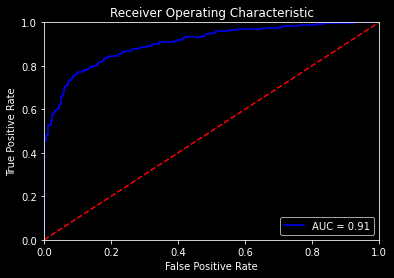

In [287]:
### prediction on val dataset
probs = bert_predict(bert_classifier, val_dataloader)
evaluate_roc(probs, y_val)

In [272]:
preds = probs[:, 1]
preds.shape

(740,)

In [273]:
from sklearn.metrics import precision_recall_curve,confusion_matrix,precision_score,recall_score,f1_score
# import plotly.express as px
# import plotly.graph_objects as go
precision,recall,thresolds = precision_recall_curve(y_val,preds)

In [274]:
y_pred = np.where(preds >= 0.5, 1, 0)

In [275]:
print("Precision: %f "%precision_score(y_val, y_pred))
print("="*40)
print("Recall: %f "%recall_score(y_val, y_pred))
print("="*40)
print("F1: %f"% f1_score(y_val, y_pred))
print("="*40)
print("Let's see the confuision matrix:\n",confusion_matrix(y_val, y_pred))
print("="*40)

Precision: 0.832447 
Recall: 0.823684 
F1: 0.828042
Let's see the confuision matrix:
 [[297  63]
 [ 67 313]]


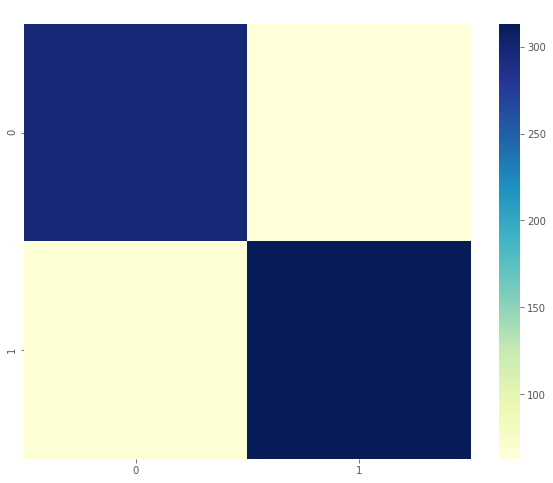

In [293]:
plt.style.use('ggplot')
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix,cmap="YlGnBu")
plt.title('Confusion Matrix')
plt.show()

In [276]:
# fig = px.area(
#     x=recall, y=precision,
#     title=f'Precision-Recall Curve (AUC={auc(fpr, tpr):.4f})',
#     labels=dict(x='Recall', y='Precision'),
#     width=700, height=500
# )
# fig.add_shape(
#     type='line', line=dict(dash='dash'),
#     x0=0, x1=1, y0=1, y1=0
# )
# fig.update_yaxes(scaleanchor="x", scaleratio=1)
# fig.update_xaxes(constrain='domain')

# fig.show()


In [277]:
# conf_matrix = confusion_matrix(y_val, y_pred)
# trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
#                         y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
#                         showscale  = False, )
# fig = go.Figure(trace1)
# fig.show()

In [278]:
#### Loading Test DataSet
def bert_predict(model, test_dataloader):
    model.eval()
    all_logits = []
    for batch in test_dataloader:
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    all_logits = torch.cat(all_logits, dim=0)
    probs = F.softmax(all_logits, dim=1).cpu().numpy()
    return probs

In [279]:
test_inputs, test_masks = preprocess_from_bert(test_df.boilerplate.values)

test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



In [280]:
probs = bert_predict(bert_classifier, test_dataloader)

threshold = 0.6
preds = np.where(probs[:, 1] > threshold, 1, 0)

print("Number of evergreen text:", preds.sum())

Number of evergreen text: 1442


In [281]:
sampleSub['label'] = preds

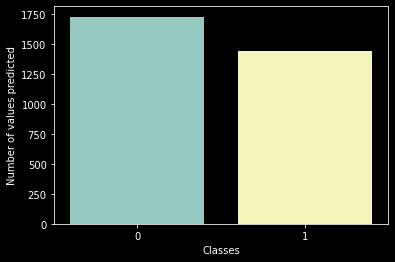

In [282]:
sns.countplot(x='label',data=sampleSub)
plt.xlabel('Classes')
plt.ylabel('Number of values predicted')
plt.show()

In [285]:
sampleSub.head(5)

,label
urlid,
5865,1
782,0
6962,1
7640,0
3589,0


In [283]:
sampleSub.set_index('urlid',inplace=True)

In [284]:
sampleSub.to_csv('finalSubmission.csv')